# Computing distance figures from speeches

This notebooks reads embedded speech vectors and their metadata and computes different distance measures between the speeches

## Imports, methods etc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel
import os
import pickle
from tqdm import tqdm

### Data locations

In [2]:
__location__ = os.path.abspath("")
sentiment_path = os.path.join(__location__, '..', 'data', 'DHH23_csvs_with_sentiment', 'ParlaMint-GB-commons_with_sentiment.csv')
speaker_dump_path = os.path.join(__location__, '..', 'data', 'speakers.csv')
pklpath = os.path.abspath(os.path.join(__location__, '..', 'data', 'ParlaMint_GB_commons_embeddings_truncated.pkl'))


### Data reading

In [3]:
def read_sentiment_csv(path):
    
    df = pd.read_csv(path)
    return df

In [17]:
def read_embeddings(path):

    with (open(path, "rb")) as openfile:
        while True:
            try:
                embeddings = pickle.load(openfile)
            except EOFError:
                break

    return embeddings

### Filtering and merging dataframes

In [5]:
def filter_df(df):

    # check if Date_datetime column exists
    if 'Date_datetime' not in df.columns:
        df['Date_datetime'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['speech_length'] = df['speech'].apply(lambda x: len(x.split()))
    # compute week
    df['week'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.week) if x.week > 9 else '0' + str(x.week)))
    df['month'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.month) if x.month > 9 else '0' + str(x.month)))
    # #filter out speeches with less than 100 words
    df = df[df['speech_length'] > 10]
    #filter out speeches where the speaker is not a mp
    df = df[df['Speaker_MP'] == 'MP']
    df = df[df['Speaker_role'] == 'Regular']
    #reset index
    df = df.reset_index(drop=True)

    return df

In [18]:
def merge_embeds_and_df(df, embeddings):

    merged_df = df.merge(embeddings, left_on='ID', right_on=embeddings.index, how='inner')

    return merged_df

## Running the Analysis

### Read sentiment CSV

In [7]:
df = read_sentiment_csv(sentiment_path)
#filter the dataframe
df = filter_df(df)
df.head()
print(len(df))

430793


### Read the embedded vectors

In [19]:
embeddings = read_embeddings(pklpath)
df_embeddings = pd.DataFrame(index=embeddings.keys())
df_embeddings['embeddings'] = embeddings.values()
df_embeddings.head()

,embeddings
ParlaMint-GB_2017-11-20-commons.u1,"[-0.052915774, -0.06561286, -0.0050254813, 0.0..."
ParlaMint-GB_2017-11-20-commons.u2,"[-0.048129626, 0.3123391, -0.008071972, -0.084..."
ParlaMint-GB_2017-11-20-commons.u3,"[0.127124, 0.031141866, -0.0068759085, 0.01661..."
ParlaMint-GB_2017-11-20-commons.u4,"[0.027221974, 0.08362359, -0.0067807273, 0.003..."
ParlaMint-GB_2017-11-20-commons.u5,"[0.040574398, 0.09211578, -0.0046407003, -0.02..."


### Merge data frames

In [20]:
mergeddf = merge_embeds_and_df(df, df_embeddings)
mergeddf.head(2)

,Unnamed: 0,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,...,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,Date_datetime,speech_length,week,month,embeddings
0,1,ParlaMint-GB_2017-11-20-commons.u2,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,...,M,-,1. What recent steps she has taken to reduce t...,What recent steps she has taken to reduce the...,-0.178467,2017-11-20,14,2017-47,2017-11,"[-0.048129626, 0.3123391, -0.008071972, -0.084..."
1,2,ParlaMint-GB_2017-11-20-commons.u3,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,...,F,-,May I take this opportunity to add my good wis...,NaN,-0.216431,2017-11-20,89,2017-47,2017-11,"[0.127124, 0.031141866, -0.0068759085, 0.01661..."


In [12]:
#list distinct weeks in df
months = mergeddf['month'].unique()
dfm = pd.DataFrame(columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches'])
dfm_median = pd.DataFrame(columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches'])
df_speakers = pd.DataFrame(columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])
for m in tqdm(months):
    #filter df to only include speeches from week w
    df_m = mergeddf[mergeddf['month'] == m]
    number_of_speeches = len(df_m)
    #filter vectors to only include speeches from week w
    vectors_m = df_m['embeddings'].values
    vectors_m = np.array([np.array(x) for x in vectors_m])
    
    #calculate mean vector for date d
    mean_vector_m = np.mean(vectors_m, axis=0)
    median_vector_m = np.median(vectors_m, axis=0)
    
    #calculate cosine similarity between mean vector and all vectors for week w
    cos_sim_m = cosine_similarity(vectors_m, mean_vector_m.reshape(1, -1))
    cos_sim_m_median = cosine_similarity(vectors_m, median_vector_m.reshape(1, -1))
    
    #list distinct parties in df_w
    parties = df_m['Speaker_party'].unique()
    #calculate mean vector for each party
    party_mean_vectors = []
    party_median_vectors = []
    for p in parties:
        #filter vectors to only include vectors where speaker party is p
        vectors_p = df_m[df_m['Speaker_party'] == p]['embeddings'].values
        vectors_p = np.array([np.array(x) for x in vectors_p])
        #calculate mean vector for party p
        mean_vector_p = np.mean(vectors_p, axis=0)
        party_mean_vectors.append(mean_vector_p)
        #calculate median vector for party p
        median_vector_p = np.median(vectors_p, axis=0)
        party_median_vectors.append(median_vector_p)
    #compute party weights
    party_weights = np.array([len(df_m[df_m['Speaker_party'] == p]) for p in parties])
    party_weights = party_weights / np.sum(party_weights)
    #compute party vector distances to mean vector
    party_distances = np.array([np.linalg.norm(mean_vector_p - mean_vector_m) for mean_vector_p in party_mean_vectors])
    party_distances = party_distances @ party_weights.T
    prtm = np.mean(party_distances)
    #compute party vector distances to median vector
    party_distances_median = np.array([np.linalg.norm(median_vector_p - median_vector_m) for median_vector_p in party_median_vectors])
    prt_median = np.median(party_distances_median)
    
    #list distinct speakers in df_w
    speakers = df_m['Speaker_name'].unique()
    #calculate mean vector for each speaker
    speaker_mean_vectors = []
    speaker_median_vectors = []
    for s in speakers:
        #filter vectors to only include vectors where speaker is s
        vectors_s = df_m[df_m['Speaker_name'] == s]['embeddings'].values
        vectors_s = np.array([np.array(x) for x in vectors_s])
        #calculate mean vector for speaker s
        mean_vector_s = np.mean(vectors_s, axis=0)
        speaker_mean_vectors.append(mean_vector_s)
        #calculate median vector for speaker s
        median_vector_s = np.median(vectors_s, axis=0)
        speaker_median_vectors.append(median_vector_s)
        #add speaker to df_speakers
        speaker_row = pd.DataFrame([[s, m, np.linalg.norm(mean_vector_s - mean_vector_m), len(vectors_s)]], columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])
        df_speakers = pd.concat([df_speakers, speaker_row])
    #compute speaker weights
    speaker_weights = np.array([len(df_m[df_m['Speaker_name'] == s]) for s in speakers])
    speaker_weights = speaker_weights / np.sum(speaker_weights)
    #compute speaker vector distances to mean vector
    speaker_distances = np.array([np.linalg.norm(mean_vector_s - mean_vector_m) for mean_vector_s in speaker_mean_vectors])
    speaker_distances = speaker_distances @ speaker_weights.T
    spkrm = np.sum(speaker_distances)
    #compute speaker vector distances to median vector
    speaker_distances_median = np.array([np.linalg.norm(median_vector_s - median_vector_m) for median_vector_s in speaker_median_vectors])
    spkr_median = np.median(speaker_distances_median)
    
    #compute mean cosine similarity for month m
    cos_sim = np.mean(cos_sim_m)
    r = pd.DataFrame([[m, cos_sim, prtm, spkrm, number_of_speeches]], columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches'])
    #add cosine similarity to dfw
    dfm = pd.concat([dfm, r])

    #compute median cosine similarity for month m
    cos_sim_median = np.median(cos_sim_m_median)
    r_median = pd.DataFrame([[m, cos_sim_median, prt_median, spkr_median, number_of_speeches]], columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches'])
    #add cosine similarity to dfw
    dfm_median = pd.concat([dfm_median, r_median])

df_speakers['monthly_mean_distance'] = df_speakers['monthly_distance'] / df_speakers['number_of_speeches']

100%|██████████| 83/83 [01:06<00:00,  1.24it/s]


### Plot mean figures

     month   cos_sim  party_distance  speaker_distance number_of_speeches
0  2015-01  0.578469        0.167961          0.942561               6461
1  2015-02  0.577262        0.163016          0.976915               4835
2  2015-03  0.588249        0.175729          0.944759               6002
3  2015-05  0.638518        0.230871          1.210246                448
4  2015-06  0.594573        0.186886          0.892535               7783


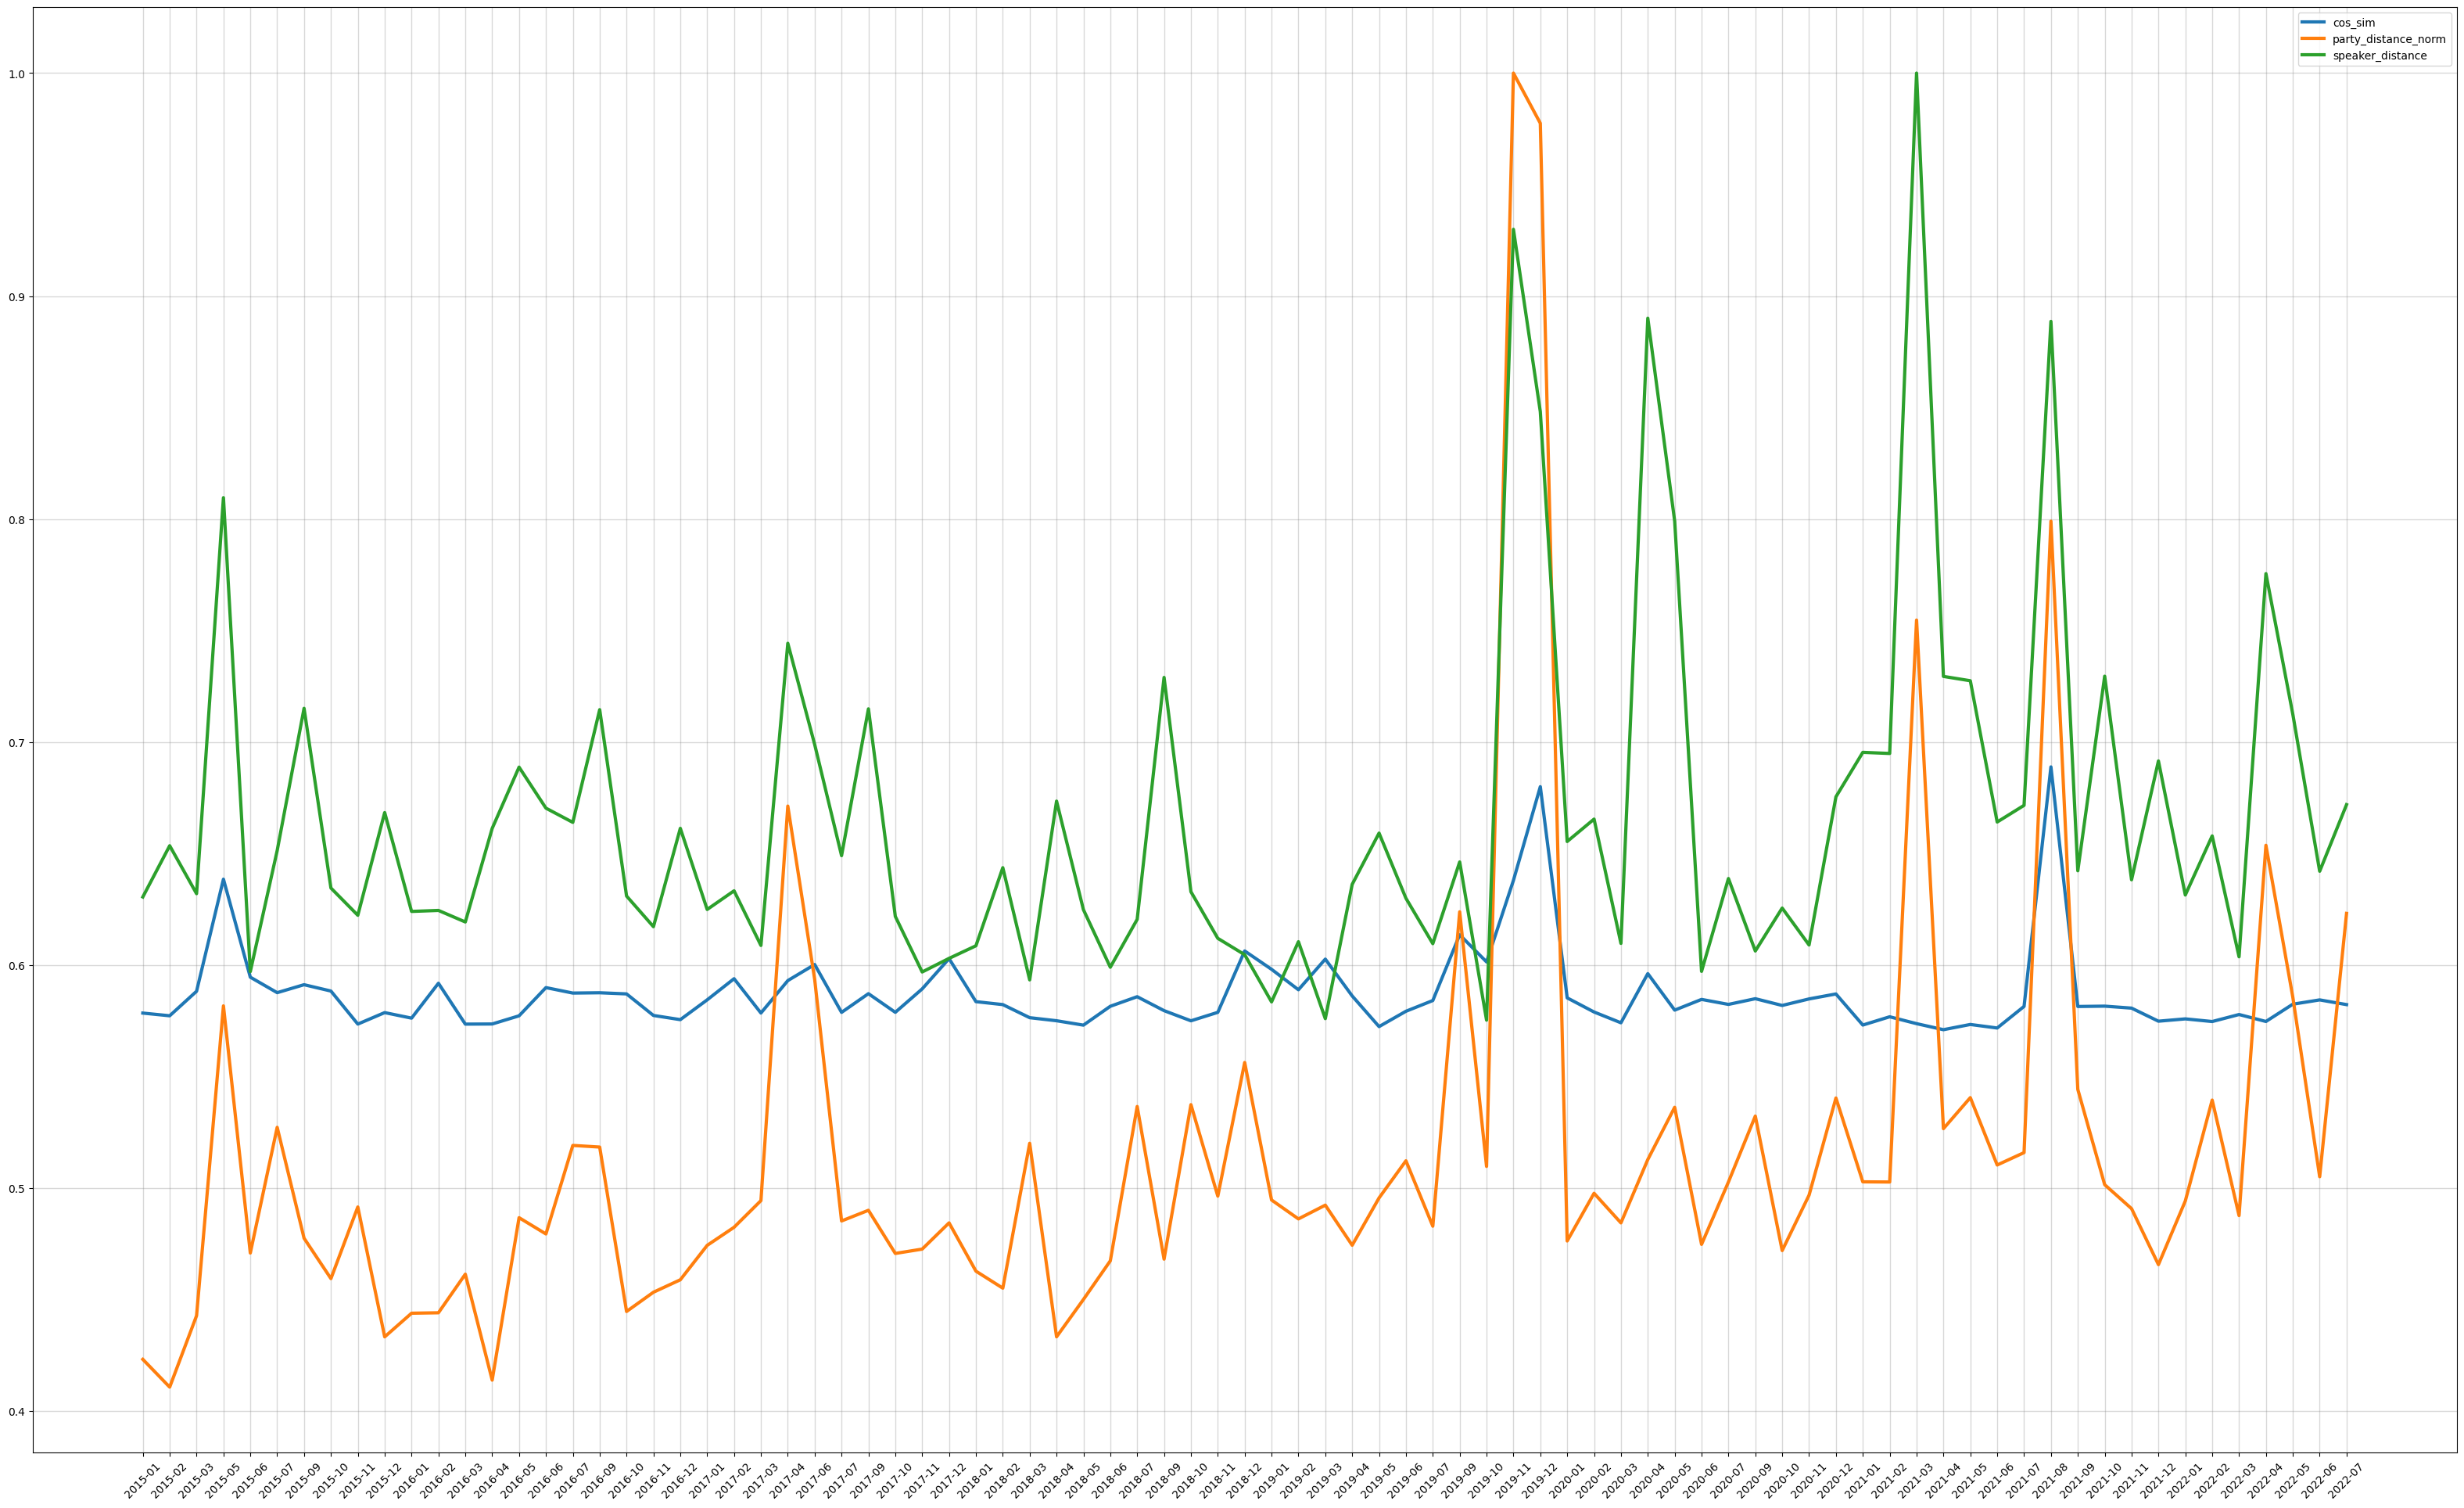

In [13]:
monthly = dfm.sort_values(by=['month']).reset_index(drop=True)
print(monthly.head())
monthly['party_distance_norm'] = monthly['party_distance'] / np.max(monthly['party_distance'])
monthly['speaker_distance_norm'] = monthly['speaker_distance'] / np.max(monthly['speaker_distance'])
plt.figure(figsize=(40,24))
plt.plot(monthly['month'], monthly['cos_sim'], linewidth=3)
plt.plot(monthly['month'], monthly['party_distance_norm'], linewidth=3)
plt.plot(monthly['month'], monthly['speaker_distance_norm'], linewidth=3)
plt.xticks(rotation=45)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.legend(['cos_sim', 'party_distance_norm', 'speaker_distance'])
plt.show()


### Plot median figures

(83,)
(83,)
(83,)
<class 'numpy.ndarray'>
729.4795077339958


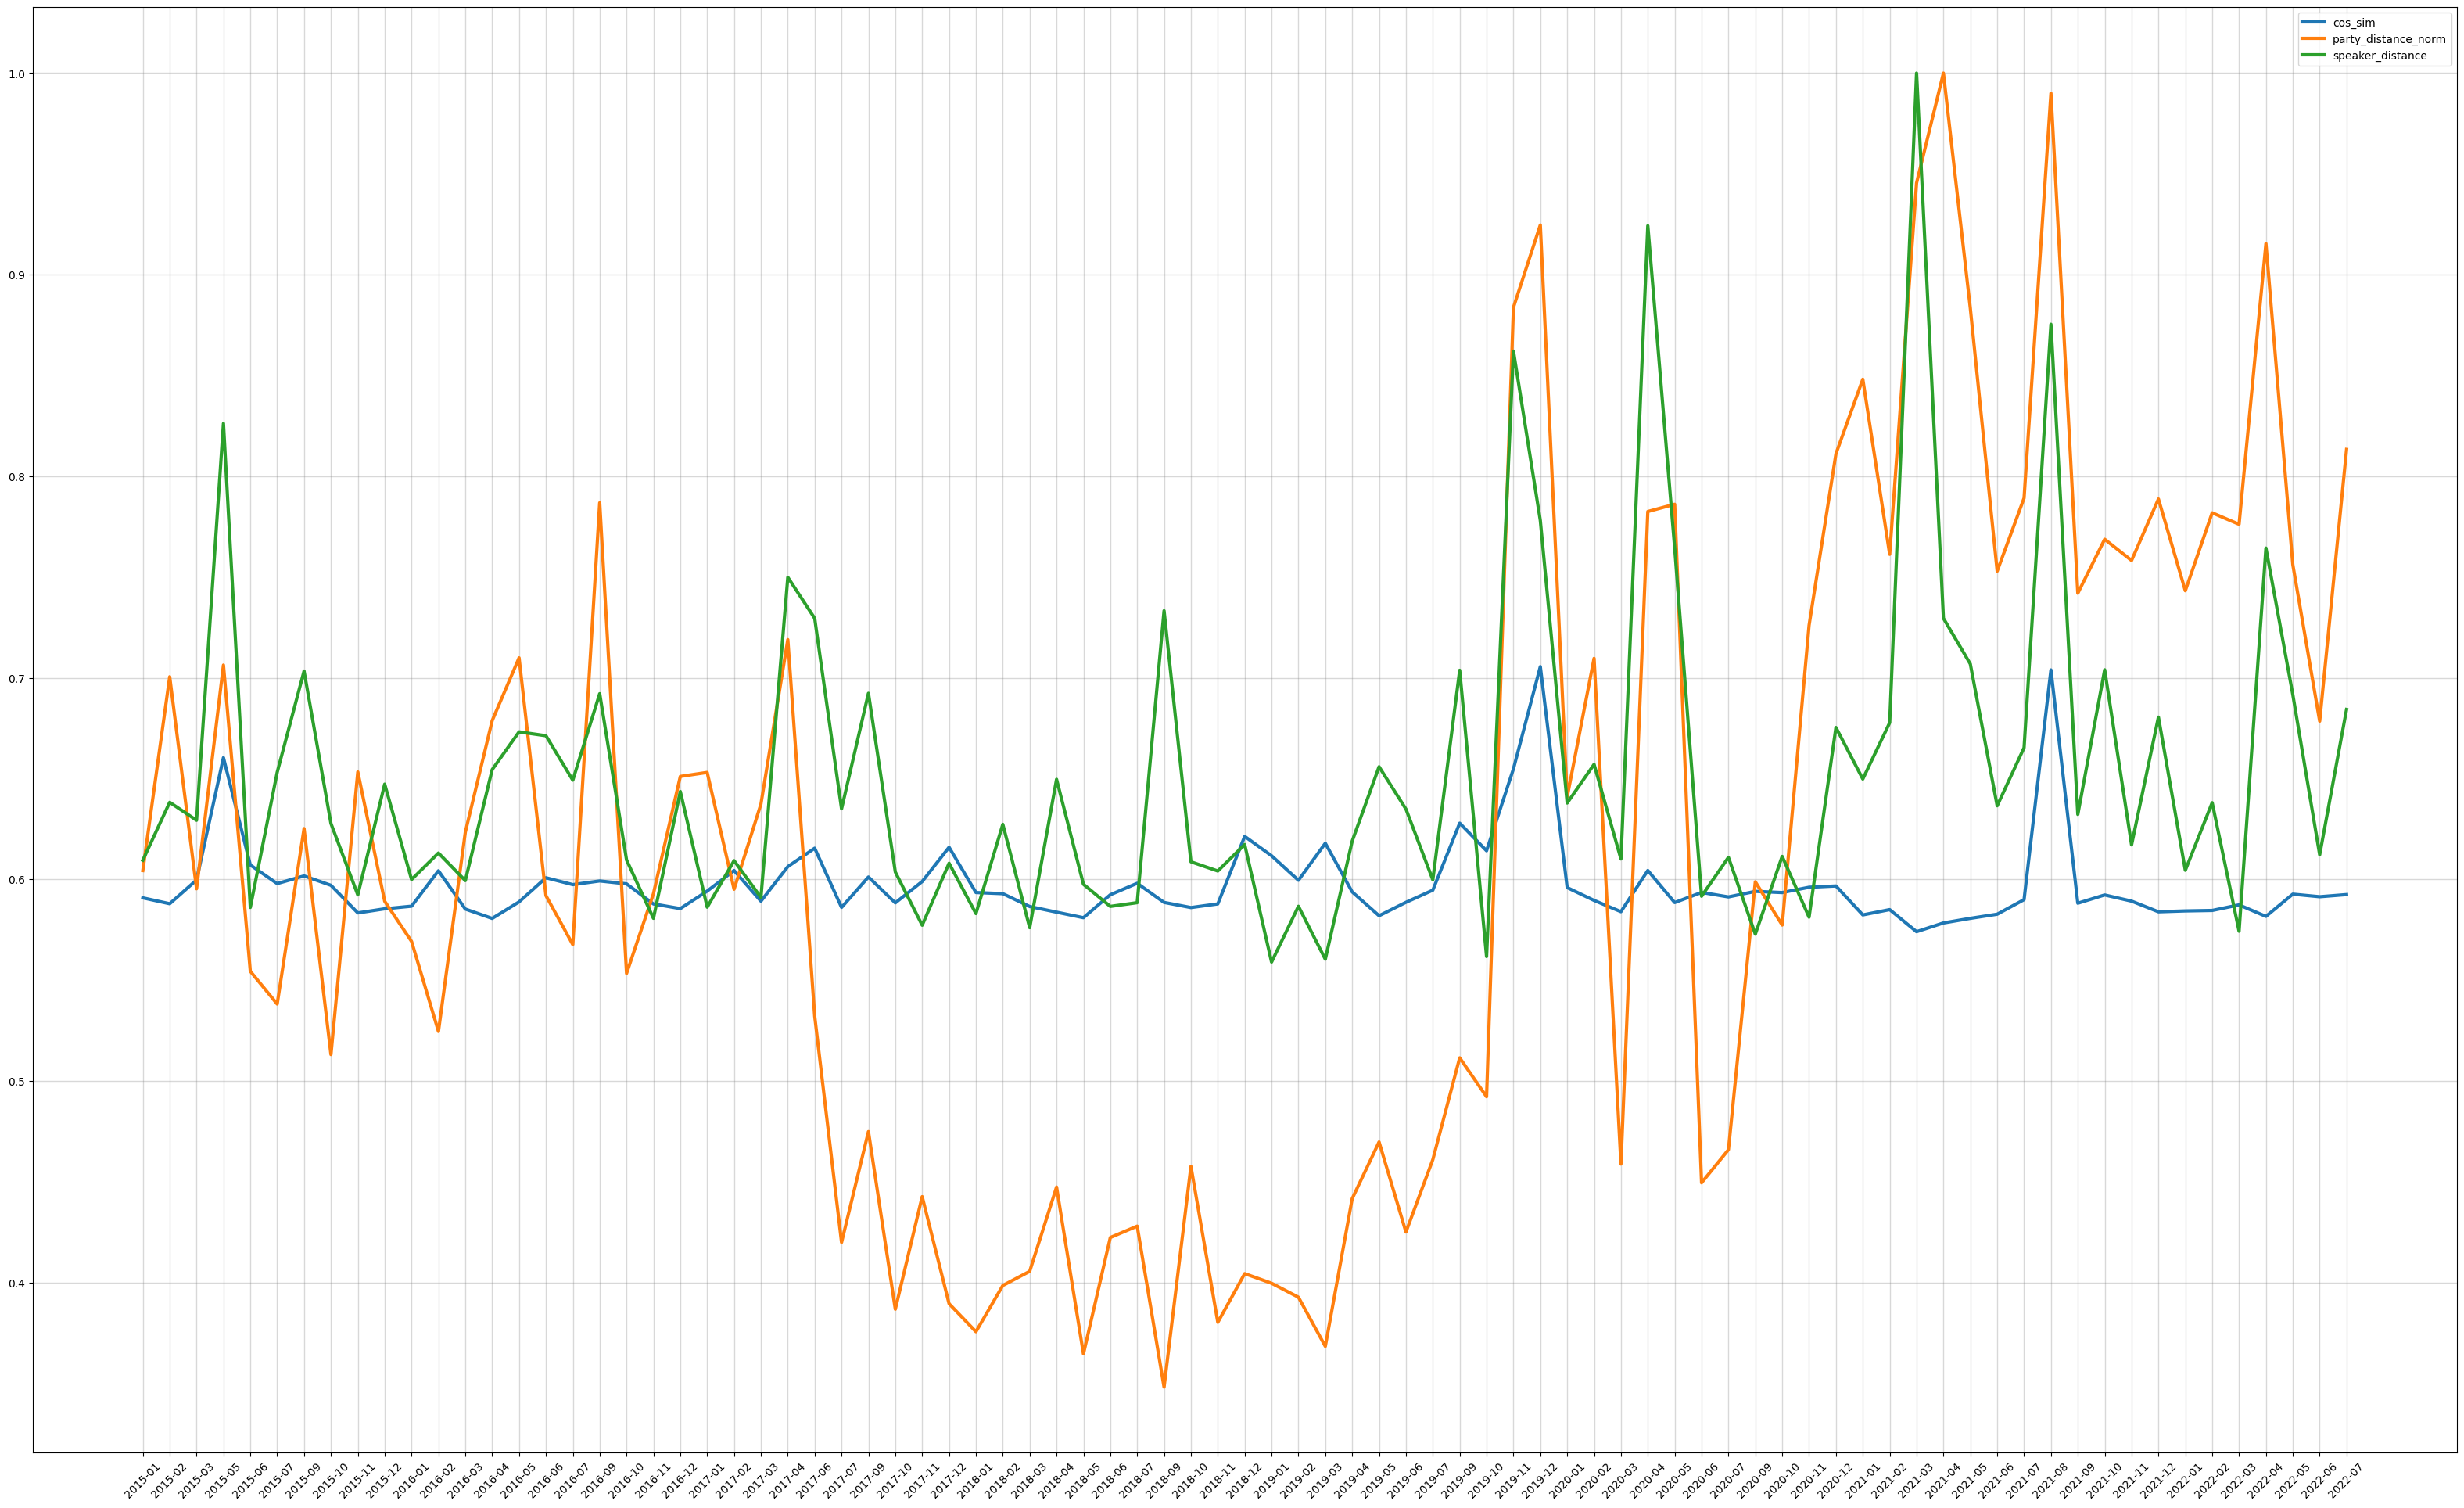

In [14]:
monthly_median = dfm_median.sort_values(by=['month']).reset_index(drop=True)
monthly_median['party_distance_norm'] = monthly_median['party_distance'] / np.max(monthly_median['party_distance'])
monthly_median['speaker_distance_norm'] = monthly_median['speaker_distance'] / np.max(monthly_median['speaker_distance'])
monthly_median['number_of_speeches_norm'] = monthly_median['number_of_speeches'] / np.max(monthly_median['number_of_speeches'])
monthly_speeches_norm = (monthly_median['number_of_speeches'] / np.max(monthly_median['number_of_speeches'])).to_numpy()
monthly_speeches_norm = monthly_speeches_norm.astype(np.float64) * 1000
plt.figure(figsize=(40,24))
print(monthly_median['month'].shape)
print(monthly_median['number_of_speeches_norm'].shape)
print(monthly_speeches_norm.shape)
print(type(monthly_speeches_norm))
print(monthly_speeches_norm[0])
plt.plot(monthly_median['month'], monthly_median['cos_sim'], linewidth=3)
plt.plot(monthly_median['month'], monthly_median['party_distance_norm'], linewidth=3)
plt.plot(monthly_median['month'], monthly_median['speaker_distance_norm'], linewidth=3)
# plt.scatter(x=monthly_median['month'], y=monthly_median['party_distance_norm'], s=monthly_speeches_norm, color='blue')
plt.xticks(rotation=45)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.legend(['cos_sim', 'party_distance_norm', 'speaker_distance'])
plt.show()

## Save Speakers CSV

In [11]:
# save speakers csv
df_speakers.to_csv(speaker_dump_path, index=False)